In [1]:
from sympy import symbols, diff, solve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from http.client import HTTPResponse, IncompleteRead
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

def patch_http_response_read(func):
    def inner(*args):
        try:
            return func(*args)
        except IncompleteRead as e:
            return e.partial
    return inner

HTTPResponse.read = patch_http_response_read(HTTPResponse.read)

# 线性回归

## 分类和回归
监督式学习的主要应用场景有两个：分类和回归。

分类就是给定特征向量，预测类别，也就是分类的输出是离散的；

回归是根据数据集$D$拟合一条曲线，输入某个$x$后，能够输出对应的预测结果，其输出是连续的，因此回归也叫做拟合(Fit)。

## 数据集的分布
在[之前](./theory.ipynb)我们讨论过某个分布$\mathcal{D}$，这是特征的分布，比如人类的身高不会异常高也不会过于矮小，而在父亲身高确定的条件下，儿子的身高也会服从$P(Y|X)$。

那么$\mathcal{D}$服从$X$和$Y$的联合分布
$$D\sim\mathcal{D}=P(X,Y)$$

## 噪音
假设线性回归的上帝函数$f$是直线，那么$y$的值是在$f(x)$的上下浮动，可以使用某个分布$\epsilon$来描述：

$$y=f(\boldsymbol{x})+\epsilon=\boldsymbol{w}\cdot\boldsymbol{x}+b+\epsilon$$

这里$\epsilon$也被称为噪音，并且其期望$E(\epsilon)=0$

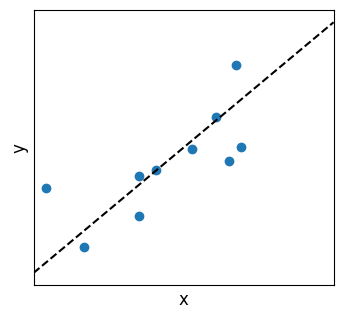

In [2]:
x_min, x_max = 1, 2.5

# 上帝函数 y=f(x)
def f(x):
	return 0.51*x+0.86

# 上帝分布 P(Y|X)
def P(X):
    # f(x) 加上期望为 0，标准差为 0.1 正态分布的噪音
	return f(X) + np.random.normal(loc = 0, scale=0.1, size=X.shape) 

# 通过 P(X, Y) 生成数据集 D
# X 服从期望为 1.718，标准差为 0.3 的正态分布
X = np.random.normal(loc = 1.718, scale=0.3, size=10) 
y = P(X)

# 绘制代码
# 设置字体大小
plt.rcParams.update({'font.size': 12})
# 设置subfigure
fig, ax = plt.subplots(figsize = (6, 3))
plt.subplots_adjust(left=0.25, right=0.75, top=0.999, bottom=0.08)
ax.set_xlabel('x'),ax.set_ylabel('y')
ax.set(xticks=[], yticks=[])
ax.set_xlim(x_min, x_max)

# 绘制数据集
ax.scatter(x=X, y=y)

# 绘制 f(x)
xx = np.linspace(x_min, x_max)
ax.plot(xx, f(xx), 'k--')

plt.show()

## 线性回归
线性回归在二维空间下是拟合一条直线，在三维下是拟合一个平面，更高维下就是拟合一个超平面，因此线性回归的假设空间维

$$\mathcal{H}=\{h(\boldsymbol{x})=\boldsymbol{w}\cdot\boldsymbol{x}+b\}$$

### 经验误差
线性回归的经验误差为
$$\hat{R}_D(h) =\frac{1}{|D|}\sum_{i}\Big(y_i-h(x_i)\Big)^2=\frac{1}{|D|}\sum_{i}\Big(y_i-(\boldsymbol{w}\cdot\boldsymbol{x_i}+b)\Big)^2$$

根据[经验误差最小原则](./theory.ipynb#经验误差最小原则)，那么可以根据$\hat{R}_D(h)$来计算出来$\boldsymbol{w}$和$b$

$$\hat{\boldsymbol{w}},\hat{b}=\operatorname*{argmin}_{\boldsymbol{w},b}\hat{R}_D(h)$$

由于$\hat{R}_D(h)$是凸函数，因此必定存在最小值，可以通过求导计算处$\boldsymbol{w}$和b

$$
\begin{cases}
    \displaystyle\frac{\partial }{\partial w}\hat{R}_D(h)=0\\
    \displaystyle\frac{\partial }{\partial b}\hat{R}_D(h)=0
\end{cases}
\implies \hat{\boldsymbol{w}}=?,\hat{b}=?
$$

并且计算出来的$\hat{\boldsymbol{w}}, \hat{b}$是$\boldsymbol{w}, b$的无偏估计。

#### 无偏估计的证明
这里我们只以$\boldsymbol{w}$和$\boldsymbol{x}$是一维向量证明

$y=wx+b+\epsilon$，那么经验误差函数为

$$\hat{R}_D(h) =\frac{1}{|D|}\sum_{i}\Big(y_i-h(x_i)\Big)^2=\frac{1}{|D|}\sum_{i}\Big(y_i-(wx_i+b)\Big)^2$$

对经验误差函数求导有

$$\begin{cases}
    \displaystyle\frac{\partial }{\partial b}\hat{R}_D(h)=-\frac{2}{|D|}\sum_{i}(y_i-b-wx_i)=0&(1)\\
    \displaystyle\frac{\partial }{\partial w}\hat{R}_D(h)=-\frac{2}{|D|}\sum_{i}(y_i-b-wx_i)x_i=0&(2)\\
\end{cases}$$

根据(1)式可得

$$\begin{aligned}
    -\frac{2}{|D|}\sum_{i}(y_i-b-wx_i)=0
        &\implies\sum_{i}(y_i-b-wx_i)=0\\
        &\implies\sum_{i}y_i-\sum_{i}b-\sum_{i}wx_i=0\\
        &\implies nb=\sum_{i}y_i-\sum_{i}wx_i\\
        &\implies b=\frac{1}{n}\sum_{i}y_i-\frac{1}{n}\sum_{i}wx_i
\end{aligned}$$

令

$$\overline{y}=\frac{1}{n}\sum_i y_i,\quad \overline{x}=\frac{1}{n}\sum_i x_i$$

因此$b=\overline{y}-w\overline{x}$，并代入(2)式可得

$$\begin{aligned}
    -\frac{2}{|D|}\sum_{i}(y_i-b-wx_i)x_i=0
        &\implies\sum_{i}(y_i-\overline{y}+w\overline{x}-wx_i)x_i=0\\
        &\implies\sum_{i}(y_i-\overline{y})x_i+w\sum_{i}(\overline{x}-x_i)x_i=0\\
        &\implies w=\frac{\displaystyle\sum_{i}(y_i-\overline{y})x_i}{\displaystyle\sum_{i}(x_i-\overline{x})x_i}
\end{aligned}$$

分子分母可以继续变形

$$\begin{aligned}
    \sum_{i}(y_i-\overline{y})x_i
        &=\sum_{i}y_ix_i-\sum_{i}\overline{y}x_i=\sum_{i}y_ix_i-\overline{y}\sum_{i}x_i\\
        &=\sum_{i}y_ix_i-\frac{1}{n}\sum_{i}y_i\sum_{i}x_i=\sum_{i}y_ix_i-\sum_{i}y_i\overline{x}\\
        &=\sum_{i}(y_ix_i-y_i\overline{x})=\sum_{i}y_i(x_i-\overline{x})
\end{aligned}$$

$$\begin{aligned}
    \sum_{i}(x_i-\overline{x})x_i
        &=\sum_{i}x_i^2-\sum_{i}\overline{x}x_i=\sum_{i}x_i^2-\overline{x}\sum_{i}x_i\\
        &=\sum_{i}x_i^2-n\overline{x}^2=\sum_{i}x_i^2-2n\overline{x}^2+n\overline{x}^2\\
        &=\sum_{i}x_i^2-2\overline{x}\sum_{i}x_i+\sum_{i}\overline{x}^2=\sum_{i}(x_i^2-2x_i\overline{x}+\overline{x}^2)\\
        &=\sum_{i}(x_i-\overline{x})^2
\end{aligned}$$

所以最终得到

$$\displaystyle\hat{w}=\frac{\displaystyle S_{xy}}{\displaystyle S_{xx}},\quad \hat{b}=\overline{y}-\hat{w}\overline{x}$$

其中：

$$\overline{y}=\frac{1}{n}\sum_i y_i,\quad \overline{x}=\frac{1}{n}\sum_i x_i$$

$$S_{xx}=\sum_i (x_i-\overline{x})^2,\quad S_{xy}=\sum_i y_i(x_i-\overline{x})$$

接下来证明无偏，以$\hat{w}$为例

$$\displaystyle\hat{w}=\frac{\displaystyle S_{xy}}{\displaystyle S_{xx}}=\sum_{i}c_iy_i,\quad c_i=\frac{x_i-\overline{x}}{S_{xx}}$$

由于$y=wx+\epsilon$，并且有$E(\epsilon)=0$，因此对$\hat{w}$求期望

$$E(\hat{w})=E(\sum_{i}c_iy_i)=E(\sum_{i}c_i(wx_i+b+\epsilon_i)=w\sum_{i}c_ix_i+b\sum_{i}c_i$$

$$\begin{aligned}
\sum_{i}c_ix_i
    &=\frac{\displaystyle\sum_{i}(x_i-\overline{x})x_i}{S_{xx}}=\frac{\displaystyle\sum_{i}(x_i^2-\overline{x}x_i)}{\displaystyle\sum_{i}(x_i-\overline{x})^2}\\
    &=\frac{\displaystyle\sum_{i}x_i^2-\overline{x}\sum_{i}x_i}{\displaystyle\sum_{i}(x_i^2-2x_i\overline{x}+\overline{x}^2)}=\frac{\displaystyle\sum_{i}x_i^2-n\overline{x}^2}{\displaystyle\sum_{i}x_i^2-2\overline{x}\sum_{i}x_i+\sum_{i}\overline{x}^2}\\
    &=\frac{\displaystyle\sum_{i}x_i^2-n\overline{x}^2}{\displaystyle\sum_{i}x_i^2-2n\overline{x}^2+n\overline{x}^2}=\frac{\displaystyle\sum_{i}x_i^2-n\overline{x}^2}{\displaystyle\sum_{i}x_i^2-n\overline{x}^2}=1
\end{aligned}$$

$$\sum_{i}c_i=\sum_{i}\frac{x_i-\overline{x}}{S_{xx}}=\frac{n\overline{x}-n\overline{x}}{S_{xx}}=0$$

所以

$$E(\hat{w})=w\sum_{i}c_ix_i+b\sum_{i}c_i=w$$

因此$\hat{w}$是$w$的无偏估计，同理$\hat{b}$也是$b$的无偏估计。

#### 从最大似然函数证明经验误差函数
假设噪音服从正态分布

$$\epsilon ~ N(0, \sigma^2)$$

并且$y$也服从正态分布，即

$$y \sim N(\boldsymbol{w}^\mathrm{T}\boldsymbol{x}, \sigma^2) $$

那么对于数据集$D$出现的概率为:


$$\begin{aligned}
    \Phi &= P(\boldsymbol{x}_1)P(y|\boldsymbol{x}_1) \times P(\boldsymbol{x}_2)P(y|\boldsymbol{x}_2) \times \cdots \times P(\boldsymbol{x}_n)P(y|\boldsymbol{x}_n) \\
        &= P(\boldsymbol{x}_1)\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_1-\boldsymbol{w}^\mathrm{T}\boldsymbol{x}_1)^2}{2\sigma^2}} \times P(\boldsymbol{x}_2)\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_2-\boldsymbol{w}^\mathrm{T}\boldsymbol{x}_2)^2}{2\sigma^2}} \times \cdots \times P(\boldsymbol{x}_n)\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_n-\boldsymbol{w}^\mathrm{T}\boldsymbol{x}_n)^2}{2\sigma^2}} \\
        &= \prod_{i=1}^{n}P(\boldsymbol{x}_i)\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_i-\boldsymbol{w}^\mathrm{T}\boldsymbol{x}_i)^2}{2\sigma^2}}
\end{aligned}$$

根据最大似然函数的思想，数据集$D$既然出现了，那么它出现的概率是最大的，也就是概率$\Phi$是最大，因此有

$$\hat{\boldsymbol{w}}=\operatorname*{argmax}_{\boldsymbol{w}}\Phi$$

由于$P(\boldsymbol{x}_i)$是固定值，换言之$X$是实际存在的某种随机变量，其满足某种分布，因此求解时可以忽略$P(\boldsymbol{x}_i)$，那么需要最大化的函数就变成

$$\Phi=\prod_{i=0}^{n}\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_i-\boldsymbol{w}^\mathrm{T}\boldsymbol{x}_i)^2}{2\sigma^2}}$$

将$\Phi$改成求和的形式

$$\ln\phi=\ln\Big(\prod_{i=1}^{n}\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_i-\boldsymbol{w}^\mathrm{T}\boldsymbol{x}_i)^2}{2\sigma^2}}\Big)=\sum_{i=1}^{n}\ln \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_i-\boldsymbol{w}^\mathrm{T}\boldsymbol{x}_i)^2}{2\sigma^2}}$$

因此

$$\begin{aligned}
    \hat{\boldsymbol{w}} &= \operatorname*{argmax}_{\boldsymbol{w}}\ln\Phi \\
    &= \operatorname*{argmax}_{\boldsymbol{w}}\sum_{i=1}^{n}\ln \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(y_i-\boldsymbol{w}^\mathrm{T}\boldsymbol{x}_i)^2}{2\sigma^2}}
\end{aligned}$$

忽略掉常数$\sigma$，那么

$$\hat{\boldsymbol{w}} = \operatorname*{argmin}_{\boldsymbol{w}}\sum_{i=1}^{n}(y_i-\boldsymbol{w}^\mathrm{T}\boldsymbol{x}_i)^2$$

因此只要噪音$\epsilon$和$y$满足正态分布，那么得到的经验误差函数和最小二乘法一致。

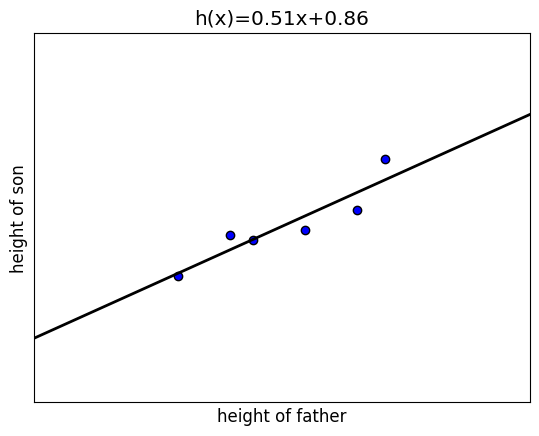

In [3]:
# 数据集 D
# 父亲身高 => 儿子身高
X = np.array([1.51, 1.64, 1.6, 1.73, 1.82, 1.87])
y = np.array([1.63, 1.7, 1.71, 1.72, 1.76, 1.86])

# 构造经验误差函数
w, b = symbols('w b', real=True)
RDh = 0
for (xi, yi) in zip(X, y):
	RDh += (yi - (xi*w + b))**2
RDh *= 1/len(X)

# 对 w 和 b 求偏导
eRDhw = diff(RDh, w)
eRDhb = diff(RDh, b)

# 求解方程组
ans = solve((eRDhw, eRDhb), (w, b))

ax = plt.subplot()
ax.set_xticks([]), ax.set_yticks([])
ax.set_xlabel("height of father")
ax.set_ylabel("height of son")
x_min, x_max = X.min()-0.25, X.max()+0.25
y_min, y_max = y.min()-0.25, y.max()+0.25
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.scatter(x=X, y=y, c="blue", marker="o", edgecolors='k')
xx=np.linspace(x_min, x_max)
yy=ans[w]*xx+ans[b]
ax.plot(xx, yy, color="black", linewidth=2)
ax.set_title(f"h(x)={ans[w]:.2f}x+{ans[b]:.2f}")
plt.show()

### 最小二乘法

由于线性回归的经验误差$\hat{R}_D(h)$是平方和，因此求解$\operatorname*{argmin}_{\boldsymbol{w},b}\hat{R}_D(h)$的方法也被称为最小二乘法。

在前面我们介绍了一个特征的求解方法，通过对$\hat{R}_D(h)$求导计算得到$\hat{\boldsymbol{w}}$和$\hat{b}$。当存在多个特征时，使用求导的计算方法会导致计算量过大，这里我们通过矩阵运算来推导一个更高效的方法来求解$\operatorname*{argmin}_{\boldsymbol{w}, b}\hat{R}_D(h)$

#### 最小二乘法的矩阵算法
首先改写函数$h$

$y=\boldsymbol{w}\cdot\boldsymbol{x}=\boldsymbol{w}^\mathrm{T}\boldsymbol{x}$

其中

$\boldsymbol{w}=\begin{pmatrix}b\\w_1\\w_2\\\vdots\\w_n\end{pmatrix},\quad\boldsymbol{x}=\begin{pmatrix}1\\x_1\\x_2\\\vdots\\x_n\end{pmatrix}$

接下来改写经验误差函数$\hat{R}_D(h)$

令

$\begin{align}
A &= (y_1-\boldsymbol{w}^\mathrm{T}\boldsymbol{x_1}, ..., y_1-\boldsymbol{w}^\mathrm{T}\boldsymbol{x_1}) \\
&= (y_1, ..., y_n)-(\boldsymbol{w}^\mathrm{T}\boldsymbol{x_1}, ..., \boldsymbol{w}^\mathrm{T}\boldsymbol{x_n}) \\
&= (y_1, ..., y_n)-\boldsymbol{w}^\mathrm{T}(\boldsymbol{x_1}, ..., \boldsymbol{x_n}) \\
&= \boldsymbol{Y}^\mathrm{T}-\boldsymbol{w}^\mathrm{T}\boldsymbol{X}^\mathrm{T} \\\\
\hat{R}_D(h) &= \frac{1}{n}AA^\mathrm{T} \\
&= \frac{1}{n}(\boldsymbol{Y}^\mathrm{T}-\boldsymbol{w}^\mathrm{T})(\boldsymbol{Y}^\mathrm{T}-\boldsymbol{w}^\mathrm{T}\boldsymbol{X}^\mathrm{T})^\mathrm{T} \\
&= \frac{1}{n}(\boldsymbol{Y}^\mathrm{T}-\boldsymbol{w}^\mathrm{T})(\boldsymbol{Y}-\boldsymbol{X}\boldsymbol{w}) \\
&= \frac{1}{n}(\boldsymbol{w}^\mathrm{T}\boldsymbol{X}^\mathrm{T}\boldsymbol{X}\boldsymbol{w}-2\boldsymbol{w}^\mathrm{T}\boldsymbol{X}^\mathrm{T}\boldsymbol{Y}+\boldsymbol{Y}^\mathrm{T}\boldsymbol{Y})
\end{align}$

最后对$\hat{R}_D(h)$求导

$\frac{\mathrm{d}}{\mathrm{d}\boldsymbol{w}}\hat{R}_D(h)=\frac{2}{|D|}X^{\text{T}}X\boldsymbol{w}-\frac{2}{|D|}X^{\text{T}}Y$

因此有

$\boldsymbol{\hat{w}}=\left(X^{\text{T}}X\right)^{-1}X^{\text{T}}Y=X^{\dagger}Y$

其中$X^{\dagger}$在数学中称为伪逆，并且只有$X$是列满秩时，$X^{\dagger}$才存在

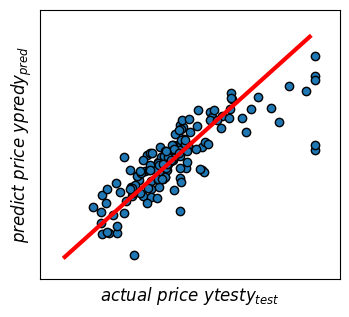

In [4]:
def load_boston():
    data_path = "data/boston"
    raw_df = pd.read_csv(data_path, sep="\\s+", skiprows=22, header=None)
    raw_df.fillna(value=-1, inplace=True)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    return data, target

X, y = load_boston()

# 没有超参数，因此只需要训练集和测试集
X0_train, X0_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state = 0)

# 训练和预测
# 构造 X_train，即给 X0_train 增加一行 1
ones = np.ones(X0_train.shape[0]).reshape(-1, 1)
X_train = np.hstack((ones, X0_train))

pinvX_train = np.linalg.pinv(X_train) # 计算伪逆
w = np.matmul(pinvX_train, y_train) # 最小二乘法的矩阵算法

# 构造 X_test，即给 X0_test 增加一行 1
ones = np.ones(X0_test.shape[0]).reshape(-1, 1)
X_test = np.hstack((ones, X0_test))

# 根据训练出来的 w ，给出预测房价 y_pred
y_pred = np.matmul(X_test, w) # 求出 y_pred

plt.rcParams.update({'font.size': 12})
# 设置画布和坐标系
fig, ax = plt.subplots(figsize = (6, 3), nrows=1, ncols=1)

fig.subplots_adjust(left=0.25, right=0.75, top=0.999, bottom=0.1, )
xy_min, xy_max = -5, 55
ax.set_xticks(()),ax.set_yticks(())
ax.set_xlim(xy_min, xy_max),ax.set_ylim(xy_min, xy_max)
ax.set_xlabel('$actual\ price\ ytesty_{test}$'),ax.set_ylabel('$predict\ price\ ypredy_{pred}$')

# 绘制点 (y_test, y_pred)
ax.scatter(x=y_test, y=y_pred, edgecolor='k',)

# 绘制直线 y_test=y_pred
xx = np.arange(xy_min + 5, xy_max - 5)
yy = xx
plt.plot(xx, yy, color = 'red', lw = 3)

plt.show()

## 非线性回归

### 特征转换
和[非线性分类运用感知机](./perceptron.ipynb)的思路一致，首先将数据集经特征转换再运用最小二乘法完成线性回归。

我们以单个特征为例，线性回归的假设空间为

$$\mathcal{H}=\{h(x)=w_0+w_1x\}$$

现在将假设空间设置为二次曲线

$$\mathcal{H}_c=\{h(x)=w_0+w_1x^2\}$$

假如上帝分布为

$$Y|X\sim x^2+\epsilon,\quad \epsilon\sim N(0,\sigma^2)$$

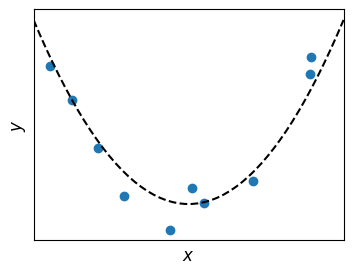

In [5]:
rnd = np.random.RandomState(3)

def f(x):
	return x**2

def P(X):
	return f(X) + rnd.normal(scale=0.1, size=X.shape)

X = rnd.uniform(-1, 1, 10)
y = P(X)

fig, ax = plt.subplots(figsize=(4, 3))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim(-1, 1)

ax.scatter(x=X, y=y)
xx = np.linspace(-1, 1)
ax.plot(xx, f(xx), 'k--')

plt.show()

[-0.04926395  1.12384697]


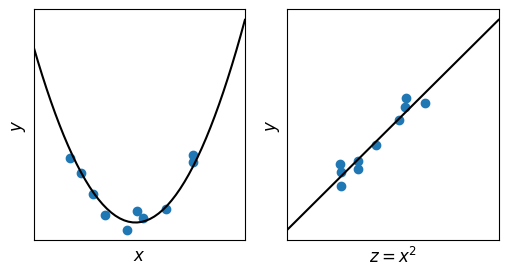

In [6]:
X_ = X.reshape(-1, 1)
ones = np.ones(X_.shape[0]).reshape(-1, 1)
X_ = np.hstack((ones, X_))
Z = X_**2

pinvX = np.linalg.pinv(Z) # 计算伪逆
w = np.matmul(pinvX, y) # 最小二乘法的矩阵算法
print(w)

fig, axes = plt.subplots(figsize=(6, 3), ncols=2, nrows=1)
xlabels = ("$x$", "$z=x^2$")
ylambdas = (lambda x: w[0]+w[1]*(x**2), lambda x: w[0]+w[1]*x)

for x, ax, xlabel, ylambda in zip((X_, Z), axes, xlabels, ylambdas):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("$y$")
    ax.set_xlim(x.min()-0.5, x.max()+0.5)
    ax.scatter(x=x[:, 1], y=y)
    xx = np.linspace(x.min()-0.5, x.max()+0.5)
    yy = ylambda(xx)
    ax.plot(xx, yy, 'k')
plt.show()

也可以使用sklearn封装好的非线性回归

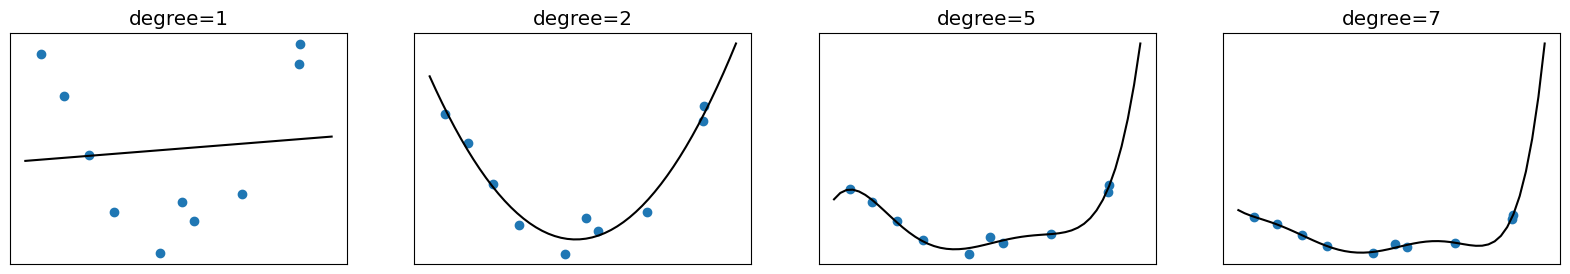

In [7]:
# 设置subfigure
x_min, x_max = -1, 1
fig, axes = plt.subplots(figsize=(20, 3), nrows=1, ncols=4)

degrees = (1, 2, 5, 7)
for ax, degree in zip(axes, degrees):
	ax.scatter(x=X, y=y)
	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_title(r"degree={}".format(degree))
	poly = PolynomialFeatures(degree=degree)	
	Z = poly.fit_transform(X.reshape(-1, 1)) # 将 X 转化为 Z
	LR = LinearRegression().fit(Z, y) # 在 zy 坐标系中进行线性回归

	xx = np.linspace(x_min, x_max)
	zz = poly.fit_transform(xx.reshape(-1, 1))
	ax.plot(xx, LR.predict(zz), 'k-')

plt.show()

### 罚项
回过头来看波士顿房价的线性回归，对于高房价，线性回归预测的效果一般，可以考虑在非线性回归的假设空间来寻找更拟合的曲线。

下面的代码使用非线性回归来拟合波士顿房价，随着模型越来越复杂，测试集上的经验误差反而增大，这是因为非线性回归找到的$h$不是[PAC](./theory.ipynb)的，这是因为$m$元$M$次多项式模型的[VC维](./theory.ipynb)是

$$d_{vc}\le{m+M\choose m}={m+M\choose M}$$

根据工程经验需要$10d_{vc}$才能保证结果是PAC的，而波士顿房价总共有506条数据，其中用于训练的占70%，也就是354条数据，并且包含13个特征，那么对于最高次数为2的多项式，其VC维为

$$d_{vc}={13+2\choose 13}=105$$

需要1050个数据才能保证结果是PAC的。

这其实是一种[过拟合](./theory.ipynb)问题，解决方法有两种
- 增大数据集$D$
- 降低模型的复杂度

In [8]:
X, y = load_boston()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state = 0)
degrees = np.array([1, 2, 3, 4, 5])
for degree in degrees:
	poly = PolynomialFeatures(degree=degree)
	Z_train = poly.fit_transform(X_train)
	LR = LinearRegression().fit(Z_train, y_train)
	Z_test = poly.fit_transform(X_test)	
	y_pred = LR.predict(Z_test)							
	print('多项式的最高次数为：{}，测试集上的经验误差为：{}'.format(degree, mean_squared_error(y_pred, y_test)))

多项式的最高次数为：1，测试集上的经验误差为：27.195965766883223
多项式的最高次数为：2，测试集上的经验误差为：29.004173897777658
多项式的最高次数为：3，测试集上的经验误差为：85912.0767178874
多项式的最高次数为：4，测试集上的经验误差为：546667.2171239312
多项式的最高次数为：5，测试集上的经验误差为：14811.522415175234


对于第二种方法，不仅可以通过减少多项式次数来降低模型的复杂度，还可以通过增加罚项(penalty term)或者正则化项(regularizer)。下面介绍机器学习中常用的罚项

$$\begin{cases}
    \displaystyle\sum_{i}I(w_i\ne 0)\le C\\
    \displaystyle\sum_{i}|w_i|\le r\\
    ||\boldsymbol{w}||^2\le r^2\\
\end{cases}$$

#### L0范数

$$\begin{aligned}
    \min_{\boldsymbol{w}}\quad
        &\hat{R}_D(h)\\
    s.t.\quad
        &\sum_{i}I(w_i= 0)\le C,\quad C\in\mathbb{N}
\end{aligned}$$

使得不超过$C$个参数$w$为0，由于示性函数$I$不可导，因此不能使用数学方法来获取最优解$\hat{\boldsymbol{w}}$，只能通过类似[感知机](./perceptron.ipynb)的口袋算法来获取可能的最优解。

#### L1范数

$$\begin{aligned}
    \min_{\boldsymbol{w}}\quad
        &\hat{R}_D(h)\\
    s.t.\quad
        &\sum_{i}|w_i|\le r,\quad r\in\mathbb{R}^+
\end{aligned}$$

L1范数也被称为Lasso回归(Least Absolute Shrinkafe and Selection Operator Regression)。

#### L2范数

$$\begin{aligned}
    \min_{\boldsymbol{w}}\quad
        &\hat{R}_D(h)\\
    s.t.\quad
        &||\boldsymbol{w}||^2 \le r^2
\end{aligned}$$

L2范数也被称为岭回归(Ridge Regression)

$$\begin{array}{c|c|c}
    \hline
    \quad\quad&\quad 形式\quad\quad&\quad 意义\quad \\
    \hline \\
    \quad L_0范数\quad & \quad\displaystyle\sum_{i}I(w_i= 0)\le C,\quad C\in\mathbb{N} \quad &\quad 在w_i中任意去除不大于C项\quad \\
    \quad L_1范数\quad & \quad\displaystyle\sum_{i}|w_i|\le r,\quad r\in\mathbb{R}^+ \quad &\quad w_i服从拉普拉斯分布，更容易取到0\quad \\
    \quad L_2范数\quad & \quad ||\boldsymbol{w}||^2\le r^2,\quad r\in\mathbb{R} \quad &\quad w_i服从正态分布，在0附近且相差不会大\quad \\
    \\
    \hline
\end{array}$$

#### 带有罚项的求解算法

这里以岭回归为例，增加了罚项后，变成了求解有条件的极值问题，可以使用拉格朗日乘数法和拉格朗日乘数法的KKT条件得到拉格朗日函数，在拉格朗日函数求极值：

$$\hat{\boldsymbol{w}}=\operatorname*{argmin}_{\boldsymbol{w}}\hat{R}_D(h)+\frac{\lambda}{|D|}||\boldsymbol{w}||^2,\lambda > 0$$

求导后可以得到

$$\boldsymbol{\hat{w}}=\left(X^{T} X+\lambda I\right)^{-1} X^{T} Y,\quad \lambda > 0$$

其中$I$是单位矩阵，$\lambda$表示惩罚力度，$\lambda$越大，罚项的惩罚力度越大。

当$\lambda$为0时表示没有罚项，模型复杂度就会很高，更容易出现过拟合的问题，而当$\lambda$过大时，由于罚项力度较大，$\boldsymbol{w}$更容易取到0，导致模型复杂度会很低，甚至变成线性的，容易出现欠拟合的问题。

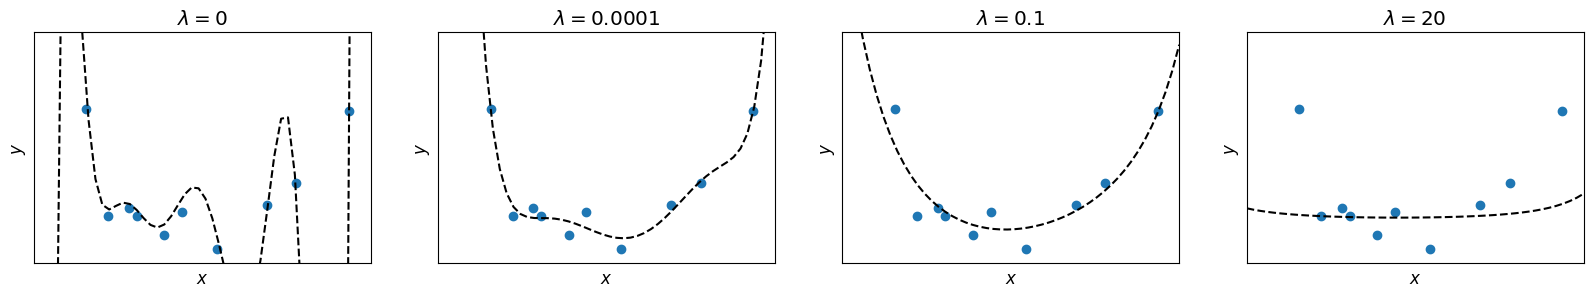

In [9]:
x_min, x_max = -1, 1
X = rnd.uniform(x_min, x_max, 10)   # 通过均匀分布产生 X
y = P(X)                            # 通过 P(Y|X) 产生 y
lambdas = (0, 0.0001, 0.1, 20)

# 利用范德蒙行列式进行特征转换
Z = np.vander(X, 11, increasing=True)

# 在转换后的坐标系下完成岭回归
zTz = Z.T @ Z
I = np.eye(zTz.shape[0])

def h(xx):
	return w[0]+w[1]*xx+w[2]*xx**2+w[3]*xx**3+w[4]*xx**4+w[5]*xx**5+\
		w[6]*xx**6+w[7]*xx**7+w[8]*xx**8+w[9]*xx**9+w[10]*xx**10

fig, axes = plt.subplots(figsize = (20, 3), nrows=1, ncols=4)
for ax, lambVal in zip(axes, lambdas):
	w = np.linalg.inv(zTz + lambVal*I) @ Z.T @ y
	ax.set(xticks=[], yticks=[])	
	ax.set_xlabel('$x$'),ax.set_ylabel('$y$')
	ax.set_xlim(x_min, x_max),ax.set_ylim(-0.2, 1.1)
	ax.set_title(r"$\lambda={}$".format(lambVal))
	ax.scatter(x=X, y=y)
	xx = np.linspace(x_min, x_max)
	ax.plot(xx, h(xx), 'k--')

plt.show()

现在我们在波士顿房价数据上加上L2罚项，并运用[K-折交叉验证](./perceptron.ipynb)的方法来选取$\lambda$参数。

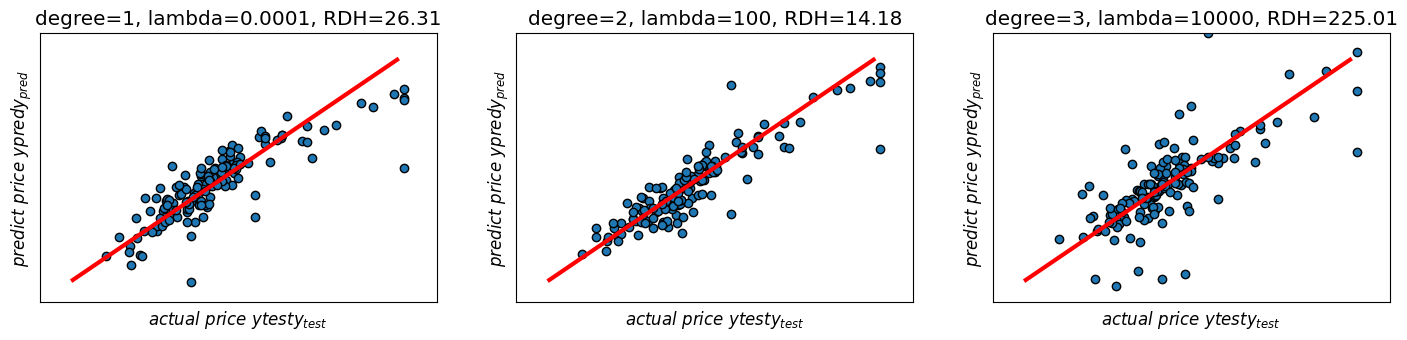

In [10]:
def train_boston_by_k_fold_cross_validation(degree, ax):
    X, y = load_boston()
    X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 20%作为测试集
    poly = PolynomialFeatures(degree=degree)
    lambdas = (0, 0.0001, 0.1, 10, 20, 100, 1000, 5000, 10000)
    best_lambda = 0
    best_error = -1

    for lambda_val in lambdas:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        error = 0
        for train, val in kf.split(X_tv):
            X_train, X_val, y_train, y_val = X_tv[train], X_tv[val], y_tv[train], y_tv[val]
            Z_train = poly.fit_transform(X_train)
            zTz = Z_train.T@Z_train
            I = np.eye(zTz.shape[0])
            w = np.linalg.inv(zTz + lambda_val*I) @ Z_train.T @ y_train
            Z_val = poly.fit_transform(X_val)
            y_pred = np.matmul(Z_val, w)
            error += mean_squared_error(y_val, y_pred)
        # print(r"lambda: {}, error: {}".format(lambda_val, error))
        if best_error < 0 or error/5 < best_error:
            best_error = error/5
            best_lambda = lambda_val
    # print(best_lambda, best_error)

    # 在整个训练集上使用超参数best_lambda训练
    Z = poly.fit_transform(X_tv)
    zTz = Z.T@Z
    I = np.eye(zTz.shape[0])
    w = np.linalg.inv(zTz + best_lambda*I) @ Z.T @ y_tv

    # 计算经验误差
    Z_test = poly.fit_transform(X_test)
    y_pred = np.matmul(Z_test, w)

    # 绘制图像
    # 设置画布和坐标系
    xy_min, xy_max = -5, 55
    ax.set_xticks(()),ax.set_yticks(())
    ax.set_xlim(xy_min, xy_max),ax.set_ylim(xy_min, xy_max)
    ax.set_xlabel('$actual\ price\ ytesty_{test}$'),ax.set_ylabel('$predict\ price\ ypredy_{pred}$')
    ax.set_title(r"degree={}, lambda={}, RDH={:.2f}".format(degree, best_lambda, best_error))
    ax.scatter(x=y_test, y=y_pred, edgecolor='k',)
    xx = np.arange(xy_min + 5, xy_max - 5)
    yy = xx
    ax.plot(xx, yy, color = 'red', lw = 3)

fig, axes = plt.subplots(figsize=(27, 3), nrows=1, ncols=3)
fig.subplots_adjust(left=0.25, right=0.75, top=0.999, bottom=0.1, )
degrees = (1, 2, 3)
for degree, ax in zip(degrees, axes):
    train_boston_by_k_fold_cross_validation(degree, ax)
plt.show()